In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

# import shutup
# shutup.please()

import jax
import jax.numpy as jnp

import numpy as np
from functools import partial

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
from rich.pretty import pprint
from tqdm.auto import tqdm

from utils.datasets import GCDataset
from agents.dynamics_aware_iql import GCIQLAgent
from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])

GLOBAL_KEY = jax.random.key(42)

In [2]:
from gymnasium.envs.registration import register
from envs.mujoco.online_env_utils import make_online_env
from envs.mujoco.ant import AntEnv

register(
    id='myant',
    entry_point=AntEnv,
    max_episode_steps=256,
    reward_threshold=-3.75,
)

env = make_online_env("myant", default_ind=2)
env.reset()

(array([ 0.84913989,  0.94857723, -0.06799677, -0.01039832,  0.00577384,
        -0.02477134, -0.08083816,  0.0320972 ,  0.04810837, -0.0104829 ,
         0.043971  ,  0.07924858,  0.05952582, -0.05524127, -0.06817184,
         0.06745775, -0.03542383,  0.15572928, -0.01716764, -0.04076779,
        -0.01839864, -0.11323715, -0.04143689,  0.05236966, -0.08584576,
         0.10763498,  0.16072241,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import functools
from utils.datasets import Dataset, GCDataset

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

selected_keys = ["observation", "next_observation", "actions", "done", "reward"]

whole_data = []
NUM_TRAIN_ENVS = 17 # total num is 20

for i in range(NUM_TRAIN_ENVS):
    cur_data = np.load(f"/home/m_bobrin/ZeroShotRL/envs/mujoco/data_custom_ant/default_ind_{i}.npz", allow_pickle=True)
    data = {key: cur_data[key] for key in selected_keys if key in cur_data.files}
    data['observations'] = data['observation']
    data['next_observations'] = data['next_observation']
    data['rewards'] = data['reward']
    del data['observation']
    del data['next_observation']
    del data['reward']
    whole_data.append(data)

whole_data = functools.reduce(concatenate_dicts, whole_data)
pprint(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))

{
│   'actions': (3400, 256, 8),
│   'done': (3400, 256),
│   'next_observations': (3400, 256, 105),
│   'observations': (3400, 256, 105),
│   'rewards': (3400, 256)
}

In [ ]:
from utils.transformer_nets import DynamicsTransformer, NextStatePrediction
from utils.flax_utils import TrainState, ModuleDict
import optax
from sklearn.manifold import TSNE

example_batch = whole_dataset.sample(1)
next_state_pred_def = NextStatePrediction(hidden_dims=(128, 128, 128), out_dim=example_batch['observations'].shape[-1])
dynamics_def = DynamicsTransformer(
    num_layers=2,
    num_heads=2,
    out_dim=8,
    action_dim=example_batch['actions'].shape[-1],
    causal=False,
    emb_dim=64,
    mlp_dim=128,
    dropout_rate=0.0,
    attention_dropout_rate=0.0,
    context_len=256
)
key, init_rng = jax.random.split(GLOBAL_KEY)
network_tx = optax.chain(
    optax.clip_by_global_norm(1.0), optax.adam(learning_rate=3e-4))
network_info = dict()
network_info.update(
                dynamic_transformer=(dynamics_def, (example_batch['observations'], example_batch['actions'],
                                                    example_batch['observations'], True))
)
network_info.update(
    next_state_pred=(next_state_pred_def, (example_batch['observations'], example_batch['actions'], jnp.zeros((1, 256, dynamics_def.out_dim))))
)
networks = {k: v[0] for k, v in network_info.items()}
network_args = {k: v[1] for k, v in network_info.items()}
network_def = ModuleDict(networks)
network_params = network_def.init(init_rng, **network_args)['params']
network = TrainState.create(network_def, network_params, tx=network_tx)

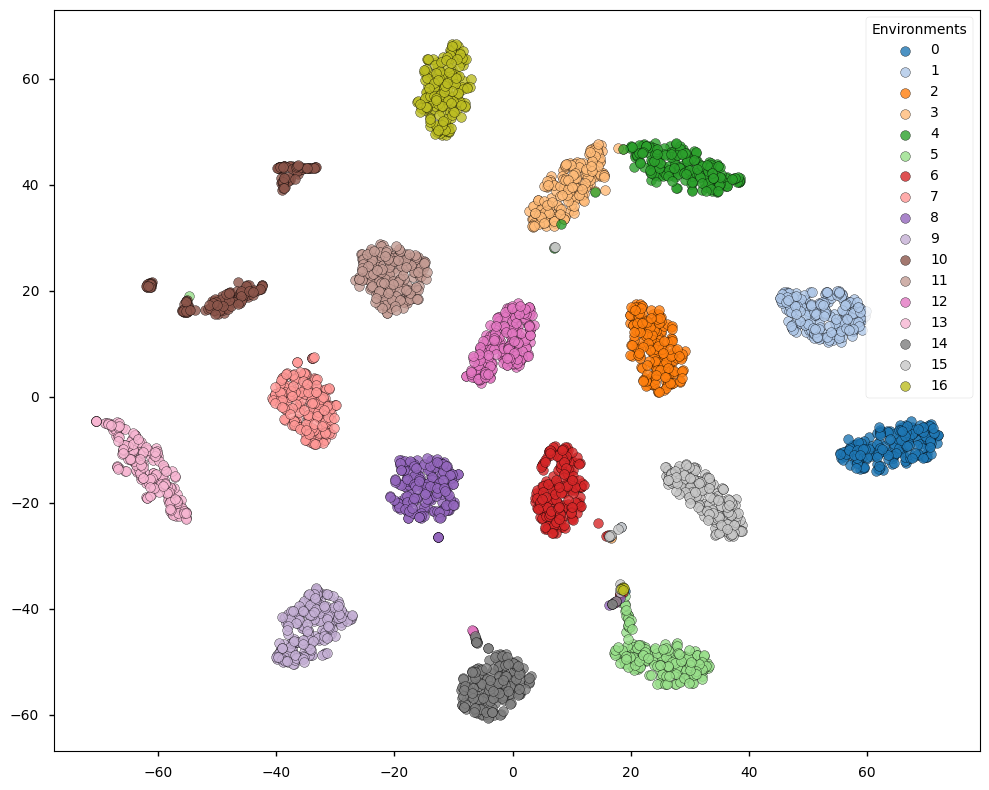

KeyboardInterrupt: 

In [9]:
from IPython.display import clear_output

def context_encoder_loss(agent, batch, grad_params, rng):
    dynamics_embedding_mean, dynamics_embedding_std = agent.select('dynamic_transformer')(batch['observations'], batch['actions'],
                                                                            batch['next_observations'], train=True, params=grad_params)
    dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=rng, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_embedding_std)
    dynamics_embedding = jnp.tile(dynamics_embedding[:, None], reps=(1, batch['next_observations'].shape[1], 1))
    next_state_pred = agent.select('next_state_pred')(batch['observations'], batch['actions'], dynamics_embedding, params=grad_params)
    loss = optax.squared_error(next_state_pred, batch['next_observations']).mean()
    return loss, {"context_embedding_loss": loss}

@jax.jit
def update(agent, batch, rng):
    def loss_fn(grad_params):
        # dyn_loss = context_encoder_loss(agent, batch, grad_params)
        return context_encoder_loss(agent, batch, grad_params, rng)
    
    agent, info = agent.apply_loss_fn(loss_fn)
    return agent, info

num_environments = 17
samples_per_env = 200

# Generate colors automatically
env_indices = np.repeat(np.arange(num_environments), samples_per_env)

pbar = tqdm(range(50_000))
for i in pbar:
    update_key = jax.random.fold_in(GLOBAL_KEY, i)
    batch = whole_dataset.sample(32)
    network, info = update(network, batch, update_key)
    
    if i % 5_000 == 0:
        clear_output()
        dynamics_embedding_mean, dynamics_embedding_std = network.select('dynamic_transformer')(whole_data['observations'], whole_data['actions'],
                                                                            whole_data['next_observations'], train=False)
        dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=update_key, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_embedding_std)
        tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
        fig, ax = plt.subplots(figsize=(10, 8))
        for i in range(num_environments):
            mask = (env_indices == i)
            ax.scatter(tsne[mask, 0], tsne[mask, 1], 
                        color=plt.cm.tab20(i), 
                        edgecolors='black',
                        label=i,
                        alpha=0.8)

        ax.legend(title="Environments")
        plt.tight_layout()
        display(fig)
        plt.close(fig)

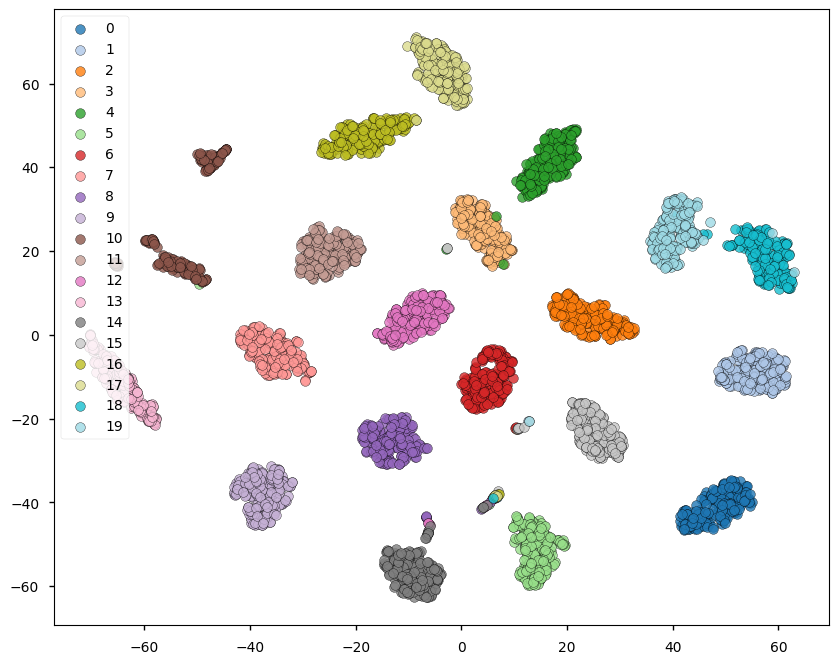

In [18]:
test_data = []
for i in range(17, 20):
    cur_data = np.load(f"/home/m_bobrin/ZeroShotRL/envs/mujoco/data_custom_ant/default_ind_{i}.npz", allow_pickle=True)
    data = {key: cur_data[key] for key in selected_keys if key in cur_data.files}
    data['observations'] = data['observation']
    data['next_observations'] = data['next_observation']
    data['rewards'] = data['reward']
    del data['observation']
    del data['next_observation']
    del data['reward']
    test_data.append(data)

test_data = functools.reduce(concatenate_dicts, test_data)
test_data = jax.tree.map(lambda x, y: jnp.concatenate([x, y]), whole_data, test_data)

dynamics_embedding_mean, dynamics_embedding_std = network.select('dynamic_transformer')(test_data['observations'], test_data['actions'],
                                                                            test_data['next_observations'], train=False)
dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=update_key, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_embedding_std)

num_environments = 20
samples_per_env = 200

# Generate colors automatically
env_indices = np.repeat(np.arange(num_environments), samples_per_env)

tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(20):
    mask = (env_indices == i)
    ax.scatter(tsne[mask, 0], tsne[mask, 1], 
                color=plt.cm.tab20(i), 
                edgecolors='black',
                label=i,
                alpha=0.8)
    ax.legend()


# Random Data

скорее всего проблема в трансе для gciql в том, что из-за того что данные рандомные, то ембединг который отдает транс плохо отделим, и когда V/Q/Actor начинают cond на пересекающиеся ембединги, то они начинают мешать друг другу
Именно поэтому даже на рандомных данных gciql работает норм на разных динамиках если подавать one-hot condition MDP
Попробовать добавить хороших данных в minigrid

In [7]:
from gymnasium.envs.registration import register
from envs.mujoco.online_env_utils import make_online_env
from envs.mujoco.ant import AntEnv
from collections import defaultdict

register(
    id='myant',
    entry_point=AntEnv,
    max_episode_steps=256,
    reward_threshold=-3.75,
)
def add_to(dict_of_lists, single_dict):
    """Append values to the corresponding lists in the dictionary."""
    for k, v in single_dict.items():
        dict_of_lists[k].append(v)

def flatten(d, parent_key='', sep='.'):
    """Flatten a dictionary."""
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if hasattr(v, 'items'):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def convert_trajs_to_dict(trajs, pad_value=0.0):
    if not trajs:
        return {}
    
    # Determine maximum trajectory length
    max_length = max(len(traj['observation']) for traj in trajs)
    
    # Initialize output dictionary
    result = defaultdict(list)
    
    # Get all field names from the first trajectory
    field_names = trajs[0].keys()
    
    for traj in trajs:
        traj_length = len(traj['observation'])
        pad_length = max_length - traj_length
        
        for field in field_names:
            # Get the array for this field
            arr = np.array(traj[field])
            
            # Pad if necessary
            if pad_length > 0:
                if arr.ndim == 1:
                    # For 1D arrays (like rewards, done)
                    arr = np.pad(arr, (0, pad_length), constant_values=pad_value)
                else:
                    # For multi-dimensional arrays (like observations, actions)
                    pad_width = [(0, pad_length)] + [(0, 0)] * (arr.ndim - 1)
                    arr = np.pad(arr, pad_width, constant_values=pad_value)
            
            result[field].append(arr)
    
    # Stack all trajectories for each field
    for field in result:
        result[field] = np.stack(result[field])
    
    return dict(result)

def evaluate_classic(
    num_eval_episodes=256,
):
    trajs = []
    stats = defaultdict(list)

    renders = []
    for env_id in tqdm(range(5), position=0, leave=True):
        env = make_online_env("myant", default_ind=env_id)
        env.reset()
        for i in tqdm(range(num_eval_episodes), position=1, leave=False):
            traj = defaultdict(list)

            observation, info = env.reset()
            done = False
            step = 0
            render = []
            while not done:
                action = env.action_space.sample()
                action = np.array(action)

                next_observation, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                step += 1

                transition = dict(
                    observation=observation,
                    next_observation=next_observation,
                    actions=action,
                    reward=reward,
                    done=done,
                    info=info,
                )
                add_to(traj, transition)
                observation = next_observation
            if i < num_eval_episodes:
                add_to(stats, flatten(info))
                trajs.append(traj)
            else:
                renders.append(np.array(render))

        # for k, v in stats.items():
        #     stats[k] = np.mean(v)

    return stats, trajs

stats, trajs = evaluate_classic()
dataset = convert_trajs_to_dict(trajs)
selected_keys = ["observation", "next_observation", "actions", "done", "reward"]
data = {key: dataset[key] for key in selected_keys if key in dataset.keys()}
data['observations'] = data['observation']
data['next_observations'] = data['next_observation']
data['rewards'] = data['reward']
del data['observation']
del data['next_observation']
del data['reward']


/home/m_bobrin/miniconda3/envs/jax2/lib/python3.10/site-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment myant already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

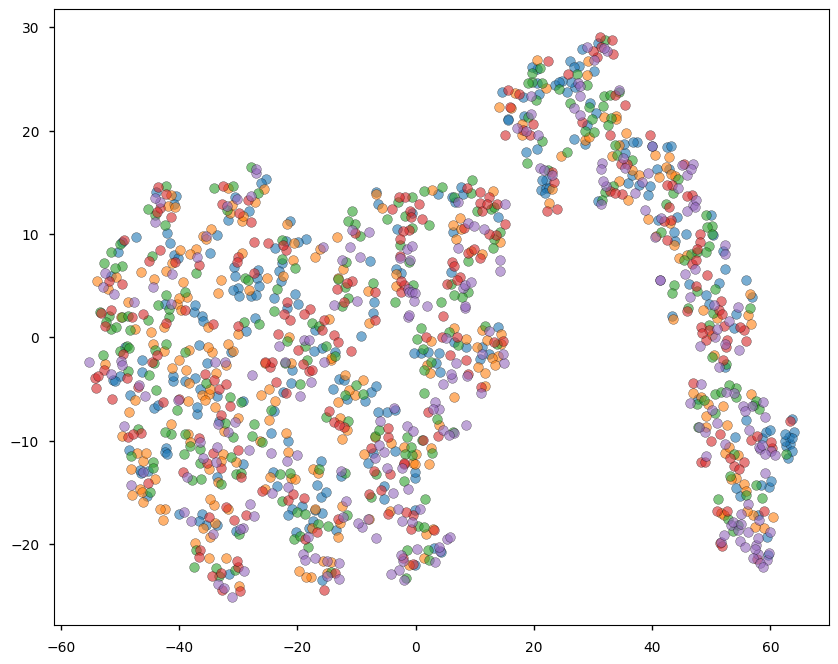

In [8]:
num_environments=5
env_indices = np.repeat(np.arange(num_environments), 256)
dynamics_embedding = network.select('dynamic_transformer')(data['observations'], data['actions'],
                                                                            data['next_observations'], train=False)
tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(num_environments):
    mask = (env_indices == i)
    ax.scatter(tsne[mask, 0], tsne[mask, 1], 
                color=plt.cm.tab10(i), 
                edgecolors='black',
                label=i,
                alpha=0.6)

In [24]:
from utils.transformer_nets import DynamicsTransformer, NextStatePrediction
from utils.flax_utils import TrainState, ModuleDict
import optax
from sklearn.manifold import TSNE
from utils.datasets import Dataset

whole_dataset = Dataset.create(**jax.device_get(data))

example_batch = whole_dataset.sample(1)
next_state_pred_def = NextStatePrediction(hidden_dims=(128, 128, 128), out_dim=example_batch['observations'].shape[-1])
dynamics_def = DynamicsTransformer(
    num_layers=2,
    num_heads=2,
    out_dim=8,
    action_dim=example_batch['actions'].shape[-1],
    causal=False,
    emb_dim=64,
    mlp_dim=128,
    dropout_rate=0.0,
    attention_dropout_rate=0.0,
    context_len=256
)
key, init_rng = jax.random.split(GLOBAL_KEY)
network_tx = optax.chain(
    optax.clip_by_global_norm(1.0), optax.adam(learning_rate=1e-4))
network_info = dict()
network_info.update(
                dynamic_transformer=(dynamics_def, (example_batch['observations'], example_batch['actions'],
                                                    example_batch['observations'], True))
            )
network_info.update(
    next_state_pred=(next_state_pred_def, (example_batch['observations'], example_batch['actions'], jnp.zeros((1, 256, 8))))
)
networks = {k: v[0] for k, v in network_info.items()}
network_args = {k: v[1] for k, v in network_info.items()}
network_def = ModuleDict(networks)
network_params = network_def.init(init_rng, **network_args)['params']
network = TrainState.create(network_def, network_params, tx=network_tx)

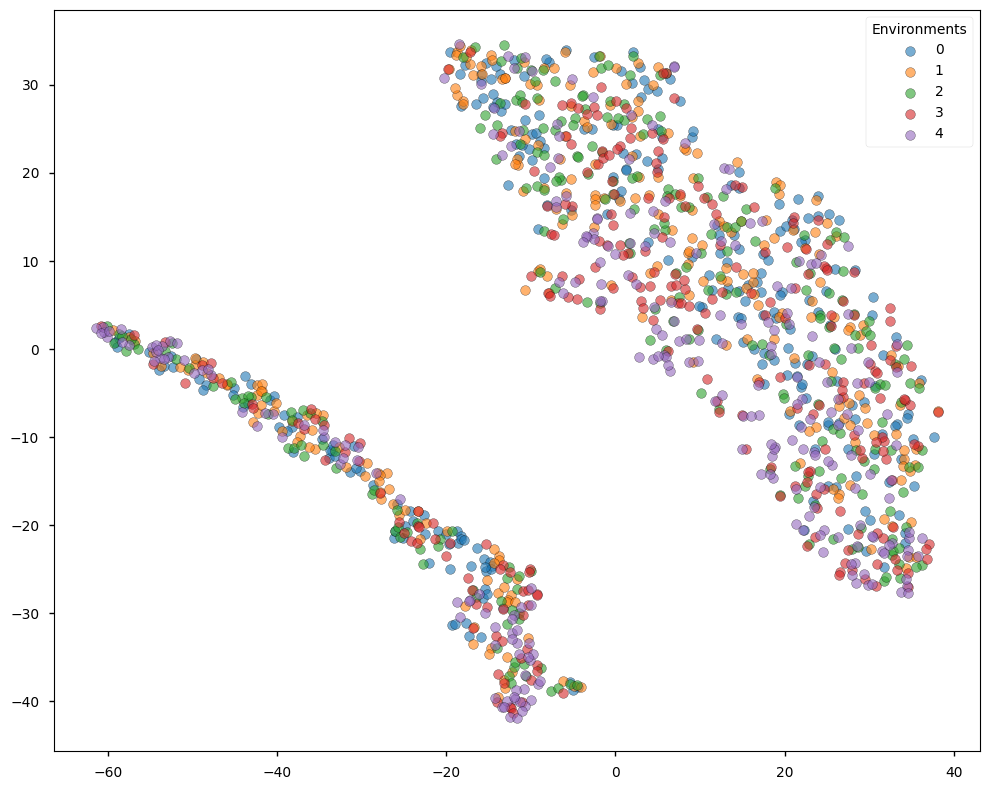

KeyboardInterrupt: 

In [26]:
from IPython.display import clear_output

def context_encoder_loss(agent, batch, grad_params):
    dynamics_embedding = agent.select('dynamic_transformer')(batch['observations'], batch['actions'],
                                                                            batch['next_observations'], train=True, params=grad_params)
    # dynamics_embedding = dynamics_embedding / jax.lax.stop_gradient(jnp.linalg.norm(dynamics_embedding, axis=1, keepdims=True))
    dynamics_embedding = jnp.tile(dynamics_embedding[:, None], reps=(1, batch['next_observations'].shape[1], 1))
    next_state_pred = agent.select('next_state_pred')(batch['observations'], batch['actions'], dynamics_embedding, params=grad_params)
    loss = optax.squared_error(next_state_pred, batch['next_observations']).mean()
    return loss, {"context_embedding_loss": loss}

@jax.jit
def update(agent, batch):
    def loss_fn(grad_params):
        # dyn_loss = context_encoder_loss(agent, batch, grad_params)
        return context_encoder_loss(agent, batch, grad_params)
    
    agent, info = agent.apply_loss_fn(loss_fn)
    return agent, info

num_environments = 5
samples_per_env = 256

# Generate colors automatically
env_indices = np.repeat(np.arange(num_environments), samples_per_env)

pbar = tqdm(range(50_000))
for i in pbar:
    batch = whole_dataset.sample(32)
    network, info = update(network, batch)
    
    if i % 5_000 == 0:
        clear_output()
        dynamics_embedding = network.select('dynamic_transformer')(data['observations'], data['actions'],
                                                                            data['next_observations'], train=False)
        tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
        fig, ax = plt.subplots(figsize=(10, 8))
        for i in range(num_environments):
            mask = (env_indices == i)
            ax.scatter(tsne[mask, 0], tsne[mask, 1], 
                        color=plt.cm.tab10(i), 
                        edgecolors='black',
                        label=i,
                        alpha=0.6)

        ax.legend(title="Environments")
        plt.tight_layout()
        display(fig)
        plt.close(fig)